<a href="https://colab.research.google.com/github/m20170548/Hands-on-NLP-with-NLTK-and-scikit-learn-/blob/master/depression_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

In [0]:
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
import os, sys
import re

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Pandas version: 0.24.2
Pytorch version: 1.1.0
Torch Text version: 0.3.1
Spacy version: 2.1.8


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
!ls "/content/gdrive/My Drive/embedding"

glove.6B.100d.txt  glove.twitter.27B.100d.txt	  uncased_L-12_H-768_A-12.zip
glove.6B.200d.txt  glove.twitter.27B.100d.txt.pt


In [0]:
df = pd.read_csv("/content/gdrive/My Drive/data/sentiment_tweets3.csv")

In [0]:
pd.set_option('display.max_colwidth', -1)

In [13]:
df.head()

,Unnamed: 0,message,label
0,106,"just had a real good moment. i missssssssss him so much,",0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0
3,288,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [14]:
df.label.value_counts()

0    8000
1    2314
Name: label, dtype: int64

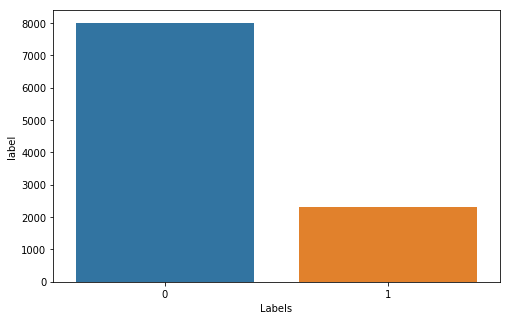

In [15]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.label.unique(),y=df.label.value_counts());
ax.set(xlabel='Labels');

In [16]:
df[df["label"]==1][:20]

,Unnamed: 0,message,label
8000,800000,The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.,1
8001,800001,i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy,1
8002,800002,"depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.",1
8003,800003,Made myself a tortilla filled with pb&j. My depression is cured. Olivia:1 depression:0,1
8004,800004,"@WorldofOutlaws I am gonna need depression meds soon, these rainouts are spinning my equilibrium out <Emoji: Pouting face> Mother Nature is being a mean B-T-H <Emoji: Face with symbols over mouth>",1
8005,800005,my anxiety and my depression fighting over whos day it is https://twitter.com/crissles/status/988218861697806336Â â¦,1
8006,800006,wow she's suddenly cured my depression and gave us world peace https://twitter.com/bearfaceingtons/status/989289124883566593Â â¦,1
8007,800007,"I am officially done with @kanyewest. him, the neptunes, justin timberlake, timbaland. got me out of depression when I was in younger. a lot of these artist have changed their sounds and I have still supported them, but this is too far",1
8008,800008,Me: what's wrong?My girl: *looks up at me with look of depression and stress on her face**Me: same babe same. #examseason,1
8009,800009,@AusBorderForce @PeterDutton_MP @shanebazzi Agreed <Emoji: Clapping hands sign><Emoji: Clapping hands sign><Emoji: Clapping hands sign>As someone with long experience of clinical depression I'd like to add this:Of course she fuckingwell yells and hits her head on the wall and says she wants to dieNobody can live forever without hopeShe won't get better while kept indefinitely on Nauru,1


In [0]:
# should try to keep emoji as one token and remove at mentions

In [17]:
# torchtext have trouble handling \n. Replace \n character with space
df['message'] = df.message.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 10314/10314 [00:00<00:00, 302190.29it/s]


In [0]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [0]:
# create train and validation set 
train_val, test = split_train_test(df, test_size=0.2)
train, val = split_train_test(train_val, test_size=0.2)

In [0]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [21]:
train.shape, val.shape, test.shape

((6600, 3), (1651, 3), (2063, 3))

[Text(0, 0.5, 'counts'), Text(0.5, 0, 'Labels'), Text(0.5, 1.0, 'test')]

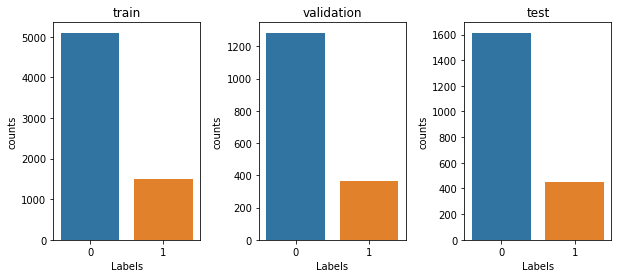

In [38]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1,3,1)
ax = sns.barplot(x=train.label.unique(),y=train.label.value_counts())
ax.set(xlabel='Labels', ylabel="counts", title="train")

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.barplot(x=val.label.unique(),y=val.label.value_counts())
ax1.set(xlabel='Labels', ylabel="counts", title="validation")

ax2 = fig.add_subplot(1,3,3)
ax2 = sns.barplot(x=test.label.unique(),y=test.label.value_counts())
ax2.set(xlabel='Labels', ylabel="counts", title="test")

In [0]:
from nltk.tokenize import TweetTokenizer 
import preprocessor as p

In [0]:
def tokenize_en(sentence):
    return [tok.text for tok in en.tokenizer(sentence)]

In [0]:
tokenizer=TweetTokenizer()

In [0]:
p.set_options(p.OPT.RESERVED, p.OPT.URL)

In [0]:
TEXT = Field(tokenize=tokenizer.tokenize)

In [0]:
TARGET = Field(is_target=True)

In [0]:
data_fields = [(None, None), ("message", TEXT), ("label", TARGET)]

In [0]:
train_data = TabularDataset(path='train.csv', format='csv', fields=data_fields, skip_header = True)

In [0]:
val_data = TabularDataset(path='val.csv', format='csv', fields=data_fields, skip_header = True)

In [0]:
print(vars(train_data[0]))

{'message': ['More', 'great', 'evidence', 'supporting', 'daily', 'exercise', 'to', 'create', 'a', 'more', 'positive', 'outlook', ':', 'Exercising', 'for', '20', 'minutes-a-day', 'cuts', 'risk', 'of', 'developing', 'depression', 'by', 'one', 'third', 'https://www.telegraph.co.uk/science/2018/04/24/exercising-20-minutes-a-day-cuts-risk-developing-depression/?WT.mc_id=tmg_share_twÂ', 'â', '\x80', '¦', 'via', '@TelegraphSci'], 'label': ['1']}


In [32]:
%%time
vec = torchtext.vocab.Vectors('glove.twitter.27B.100d.txt', '/content/gdrive/My Drive/embedding')

100%|█████████▉| 1193335/1193514 [00:55<00:00, 20324.68it/s]

CPU times: user 58.7 s, sys: 2.43 s, total: 1min 1s
Wall time: 1min 2s


In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors=vec)

TARGET.build_vocab(train_data)

In [34]:
print(TEXT.vocab.stoi['the'])

6


In [35]:
print(TEXT.vocab.itos[:20])

['<unk>', '<pad>', '.', '!', ',', 'to', 'the', 'a', 'I', 'and', 'you', 'of', 'depression', 'my', 'for', 'is', '?', 'in', 'it', '...']


In [36]:
TEXT.vocab.vectors.shape

torch.Size([19686, 100])

In [38]:

TEXT.vocab.vectors[TEXT.vocab.stoi['the']]

tensor([ 9.5152e-02,  3.7024e-01,  5.4291e-01,  1.9621e-01,  4.8205e-02,
         3.2033e-01, -5.9638e-01,  1.5868e-02, -1.2989e-01, -6.3028e-01,
         8.1944e-02,  2.4164e-01, -6.0990e+00, -6.8557e-01,  5.0354e-01,
        -3.4089e-02,  1.1705e-01, -7.7403e-03, -8.6512e-02,  4.3617e-01,
        -4.3982e-01,  2.6125e-01, -4.0348e-02, -1.9194e-01,  8.3204e-02,
        -5.8246e-01, -3.1923e-02,  1.2630e-01,  4.0120e-01,  6.8906e-02,
        -1.0517e-01, -2.0804e-01, -4.2554e-01,  4.7799e-01,  3.4651e-01,
         2.4057e-01,  5.0244e-02, -7.2587e-02, -2.4347e-03, -5.0342e-01,
        -1.0601e+00, -3.1586e-01, -3.2457e-02, -7.6317e-02,  7.9045e-01,
         8.6367e-02, -1.9632e-01,  5.7566e-02,  8.4129e-01, -4.2020e-01,
        -1.1335e-03, -8.5632e-02,  6.1910e-02,  2.1423e-01, -1.0356e-01,
        -3.6946e-02, -2.6005e-01, -3.5657e-01,  5.4321e-02,  3.0875e-02,
         1.4092e-01, -9.1998e-02, -4.1841e-01, -3.1135e-01, -1.4937e-01,
        -2.2699e-04, -3.3454e-01, -1.4848e-01, -1.1

In [1]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

NameError: ignored